## 1️⃣Data Collect(jupyter환경 진행)

In [ ]:
# 참고내용
# CNN
# 'C:\\Users\\RYU\\MLDL_Likelion\\Part 6. 딥러닝 핵심 이론 & TF를 활용한 딥러닝 실습\\실습 파일 (부록)\\(Misc.) 1. cvlib을 활용한 편리한 얼굴 & 물체 검출'
# 'C:\\Users\\RYU\\MLDL_Likelion\\Part 6. 딥러닝 핵심 이론 & TF를 활용한 딥러닝 실습\\실습 파일 (메인)\\(Appendix) 4. TF2.0 Tensorboard & Keras for CNN MNIST (+ Colab GPU with GoogleDrive)'
# 'C:\\Users\\RYU\\MLDL_Likelion\\Part 6. 딥러닝 핵심 이론 & TF를 활용한 딥러닝 실습\\실습 파일 (메인)\\(Appendix) 2. Build, Train, and Visualize CNN models (CNN Basic)'

# DNN
# 'C:\\Users\\RYU\\MLDL_Likelion\\Part 6. 딥러닝 핵심 이론 & TF를 활용한 딥러닝 실습\\실습 파일 (메인)\\(Appendix) 3. CNN for Fashion MNIST & CIFAR10 (+Transfer learning)'

### Image Scraping

In [ ]:
## colab install
# !pip install selenium
# !apt-get update
# !apt install chromium-chromedriver

In [ ]:
# !pip install cvlib

     |████████████████████████████████| 10.0 MB 9.0 MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.6-py3-none-any.whl size=10044620 sha256=6e4fef2b0ef56de0e0794f198cba3dff20fe887f4b80ce81cddb9ad97313e5bc
  Stored in directory: /root/.cache/pip/wheels/9b/96/9b/373c07517ffe0bedbebc0813aec1e62cb2bb1dee91b3694895
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=87d40b98312c2a58c897b80ee2e8e1045b72306612788e99e84372acb72083dc
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built cvlib progressbar


In [ ]:
# !pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 4.5 MB/s 


In [ ]:
# from selenium import webdriver # colab에서는 skip

# image webscraping
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd
import urllib.request
import glob

# Deep Learning (CNN)
import cv2
# import cvlib as cv
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np

# CNN HPO
# from keras import initializers
# import kerastuner as kt
# import IPython

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# etc..
import os
## tf.logging.set_verbosity(tf.logging.ERROR) #colab에선 주석처리 필요
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [ ]:
# print("tensorflow",tf.__version__) #2.5.0
# print("keras",keras.__version__) #2.5.0
# print("IPython",IPython.__version__) #5.5.0
# print("pandas",pd.__version__) #1.1.5
# print("numpy",np.__version__) #1.19.5
# print("cvlib",cv.__version__) #0.2.5
# print("opencv",cv2.__version__) #4.1.2

tensorflow 2.5.0
keras 2.5.0
IPython 5.5.0
pandas 1.1.5
numpy 1.19.5
cvlib 0.2.5
opencv 4.1.2


### Image URL address scraping

In [ ]:
item_num = "685185" #"685185" - 신발1, "497858"-슬리퍼2, "1789507"-가방, "903340" -상의. "750908"- 하의
base_url = "https://store.musinsa.com/app/goods/"
url = base_url + item_num

In [ ]:
# colab 에서 처리할때 하단 주석코드 추가
# chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--headless')
# chrome_options.add_argument('--no-sandbox')
# chrome_options.add_argument('--disable-dev-shm-usage')


# driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options) #colab
driver = webdriver.Chrome(executable_path='(driver) chromedriver.exe') #local

driver.get(url)

In [ ]:
img_url_lst = []
img_url_temp_lst = []
img_url_right_lst = [] # 제대로 후기를 올린 사진들
img_url_wrong_lst = [] # 후기를 잘못 올려서 고객센터에서 댓글을 올려진 사진들

In [ ]:
# 페이지값 가져오기
web = driver.page_source
soup = BeautifulSoup(web, 'html.parser')
range_tag = soup.find("div",{"class":"wrap review_list_detail style_review"}).find_all('div', {"class":"box_page_msg"})
range_temp = range_tag[0].get_text(strip=True)

# range 함수는 end 값에서 -1까지만 가므로,
range_num = int(range_temp.split(sep=' 페이지')[0]) + 1

In [ ]:
# 한 page당 10개의 review
# 1~100page 이동
# total 1000개의 Data확보
# scraping_url_dir = soup.find_all('li', {"class":"review-content-photo__item"})



for i in range(1,range_num):
    # Page이동 - java script code실행
    driver.execute_script("viewEstimateByPage('497858','0',{},'style','1865908','','N','new'); return false;".format(i))
    time.sleep(2) # selenium 특성상, loading속도를 못따라갈 수 있으므로 2초씩 sleep진행
    web = driver.page_source # selenium으로 열어둔 driver의 현재 page로 접근
    soup = BeautifulSoup(web, 'html.parser')
    # html문서로 전체 페이지 불러오기
    scraping_url_path = soup.find_all('div', {"class":"review-list"})
    for img_path in scraping_url_path:
        try:
            # 무신사가 댓글을 달았을때, 무신가 관리자 썸네일이 있으면 에러가 나지 않음.(Wrong)
            img_path.find_all('img', {"alt":"무신사 관리자 썸네일"})[0]
            # style 후기 일때만
            try:
                if img_path.find_all('a', {"class":"review-profile__link"})[0]['href'].find('photo') < 0:
                    temp_ = img_path.find_all('li', {"class":"review-content-photo__item"})[0]('img')[0]['src']
                    # 잘못 후기올린 (전신사진x) 사진들을 Wrong 리스트에 url 넣기
                    img_url_wrong_lst.append("https:"+temp_)

            except:
                pass
        except:
            # 무신사가 댓글을 달지 않았을때, 에러가 남 (Right)
            # style 후기 일때만
            try:
                if img_path.find_all('a', {"class":"review-profile__link"})[0]['href'].find('photo') < 0:
                    temp_ = img_path.find_all('li', {"class":"review-content-photo__item"})[0]('img')[0]['src']
                    img_url_right_lst.append("https:"+temp_)

            except:
                pass
            
# # page 이동 시에 url이 바뀌지 않아서 선택한 방법
# # # page이동 방법1 - java code 실행시키기
# # driver.execute_script("viewEstimateByPage('685185','0','2','style','685185','','N','new'); return false;")
        
# # # page이동 방법2 - css 코드에서 찾기
# # driver.find_elements_by_css_selector('#wrapStyleEstimateList > div > div.nslist_bottom > div.pagination.textRight > div > a')[4].click()

# # direct 접근방법
# # soup.find("div",{"class":"wrap review_list_detail style_review"}).find_all('li', {"class":"review-content-photo__item"})

In [ ]:
driver.close()
driver.quit()

In [ ]:
# 중복제거
img_url_right_lst = list(set(img_url_right_lst))
img_url_wrong_lst = list(set(img_url_wrong_lst))

In [ ]:
# save as df
img_url_right_lst=pd.DataFrame(img_url_right_lst,columns=['url'])
img_url_wrong_lst=pd.DataFrame(img_url_wrong_lst,columns=['url'])
img_url_right_lst.to_csv('img_url_right_lst.csv',encoding='utf-8')
img_url_wrong_lst.to_csv('img_url_wrong_lst.csv',encoding='utf-8')

In [ ]:
# load url list
img_url_right_lst = pd.read_csv('img_url_right_lst.csv',encoding='utf-8')
img_url_wrong_lst = pd.read_csv('img_url_wrong_lst.csv',encoding='utf-8')
df_img_right_url = img_url_right_lst.iloc[:,1:]
df_img_wrong_url = img_url_wrong_lst.iloc[:,1:]

img_url_right_lst = df_img_right_url['url'].tolist()
img_url_wrong_lst = df_img_wrong_url['url'].tolist()

#### image save

In [ ]:
# images folder 생성
# # local
# os.mkdir(os.getcwd()+"\\images_wrong")
# os.mkdir(os.getcwd()+"\\images_right")


# colab
# os.mkdir("/content/images_wrong")
# os.mkdir("/content/images_right")

In [ ]:
# img url list 에서 각각의 url로부터 image file 'images0000.jpg'를 저장
# right 이미지 다운로드
for index, url in enumerate(img_url_right_lst):

    urllib.request.urlretrieve(url, "images_right/images{0:04}.jpg".format(index))
    
    if index%100 == 0:
        print('Downloaded image # :', index)
    time.sleep(0.4)
print('Download completed!')

Downloaded image # : 0
Downloaded image # : 100
Downloaded image # : 200
Downloaded image # : 300
Downloaded image # : 400
Downloaded image # : 500
Downloaded image # : 600
Downloaded image # : 700
Downloaded image # : 800
Downloaded image # : 900
Downloaded image # : 1000
Downloaded image # : 1100
Download completed!


In [ ]:
# right이미지와 구분하기 위해_파일명 변경
# wrong 이미지 다운로드
for index, url in enumerate(img_url_wrong_lst):

    urllib.request.urlretrieve(url, "images_wrong/images_wrong_{0:04}.jpg".format(index))
    
    if index%100 == 0:
        print('Downloaded image # :', index)
    time.sleep(0.4)
print('Download completed!')

## 2️⃣Image Data Visualization

### Image Data Load✅

In [ ]:
# Data Reload
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip -qq "/content/drive/MyDrive/멋쟁이사자처럼_파이널프로젝트/images.zip" -d "/content/images"

replace /content/images/no/no (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!unzip -qq "/content/drive/MyDrive/멋쟁이사자처럼_파이널프로젝트/test_images.zip" -d "/content/test_images"

N
replace /content/test_images/no/images0003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Visualization

In [ ]:
# Data dir 확인
train_ok_dir = os.path.join('images/point')
train_no_dir = os.path.join('images/no')
print(len(os.listdir(train_ok_dir))) 
print(len(os.listdir(train_no_dir))) 

7583
2109


In [ ]:
import matplotlib.image as mpimg

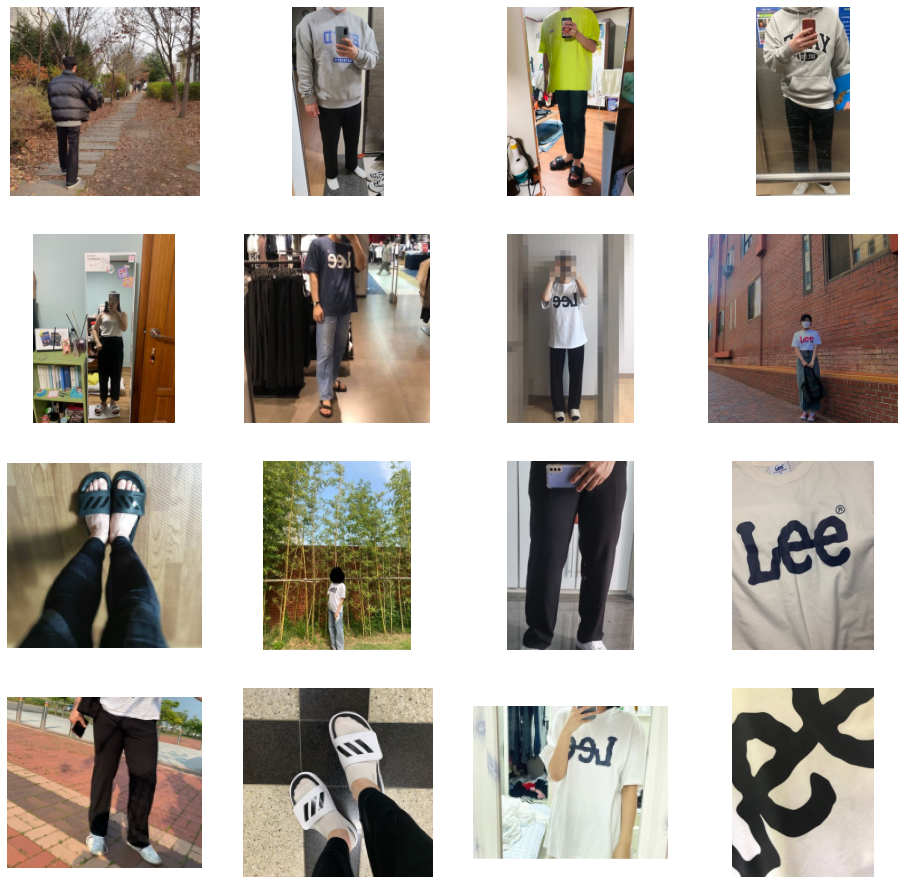

In [ ]:
train_ok_names = os.listdir(train_ok_dir)
train_no_names = os.listdir(train_no_dir)

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
 
# Index for iterating over images
pic_index = 0

# 4X4 plot 구성 setting
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
 
pic_index += 8
next_ok_pix = [os.path.join(train_ok_dir, fname) 
                for fname in train_ok_names[pic_index-8:pic_index]]
next_no_pix = [os.path.join(train_no_dir, fname) 
                for fname in train_no_names[pic_index-8:pic_index]]
 
for i, img_path in enumerate(next_ok_pix+next_no_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## 3️⃣Deep Learning

### Data Generating✅

In [ ]:
# Data 불러오기
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
# float32여야지 CNN이 동작해서 1./255
# 255개의 pixel을 나눠서 min-max standardization한다고 보면됨


# augmented data 불러오기
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   rotation_range = 20,
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1,
                                   brightness_range = [.2, .2],
                                   horizontal_flip = True,
                                   #validation_split = .1
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')

 
# 'train_datagen' 이라는 generator를 이용해서 모든 데이터를 긁어옴 
train_generator_augmented = train_datagen.flow_from_directory(
        'images', # images folder에 있는 all images 불러오기
        target_size=(300, 300),  # all images 사이즈 300X300변경
        classes=['no', 'point'], # colab환경에서 돌리면 폴더수+1개의 class로 분류함
        batch_size=32, # epoch당 들어가는 image 파일수
        class_mode='binary')     # 적립금 지급 or 댓글 대상으로 이진분류를 할것이기 때문에 binary선택.

Found 9692 images belonging to 2 classes.


In [ ]:
# 똑바로 서있는 train data 불러오기
train_datagen_vertical = ImageDataGenerator(rescale = 1./255)
train_generator_vertical = train_datagen_vertical.flow_from_directory(
        'images',
        target_size=(300, 300), 
        classes=['no', 'point'],
        batch_size=32, 
        class_mode='binary')

Found 9692 images belonging to 2 classes.


In [ ]:
# test Data 불러오기
test_datagen = ImageDataGenerator(rescale = 1./255,)
test_generator = test_datagen.flow_from_directory(
        'test_images', # test_images folder에서 사진가져오기. directory임 잊지말것.
        target_size=(300, 300),
        classes=['no', 'point'],
        batch_size=32,
        class_mode='binary')

Found 1113 images belonging to 2 classes.


### 1. CNN Learning

In [ ]:
# modeling

# Batch normalization을 추가하는것을 고려해볼것
# https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3),padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
        

    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2), # pooling size를 2by2로해서, output은 300x300넣으면 150x150으로 반쪽이됨.
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('no') and 1 for the other ('point')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 64)       

**binary cross entropy**<br>
개념 : https://curt-park.github.io/2018-09-19/loss-cross-entropy/<br>
활용 : https://han-py.tistory.com/266<br>
  - 한줄 정리 : 두 개의 확률분포 p와 q에 대해 하나의 사건 X가 갖는 정보량으로, q 에 대한 정보량을 p에 대해서 평균낸 것 <br>
  - 활용적 관점 정리 : 
    - label-0 or 1 / sigmoid함수로 loss 설정 時 - binary_crossentropy
    - label-0 or 1 / softmax함수로 loss 설정 時 - sparse_categorical_crossentropy
    - label [0,1] or [1,0] / softmax함수로 loss 설정 時 - categorical_crossentropy

In [ ]:
model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
reduce_lr = ReduceLROnPlateau(patience=8,verbose=1) # 8번의 epoch가 지났는데도 개선이 없으면, learning rate를 수정함
early_stop = EarlyStopping(patience=10,verbose=2,monitor='val_loss')


model_save_folder_path= './drive/MyDrive/final_model/'
if not os.path.exists(model_save_folder_path): #없으면 model 폴더 생성
  os.mkdir(model_save_folder_path)

model_path = model_save_folder_path + 'model_{epoch:03d}-{val_acc:.4f}.hdf5' #hdf5파일로 저장

model_ckpt = ModelCheckpoint(filepath=model_path,
                             monitor='val_acc', # test data에 대한 정확도를 기준으로 checkpoint를 만들겠다.
                             verbose=1, 
                             save_best_only=True # 20번의 epochs중 monitor로 설정한값이 개선된 경우에만 저장
                             )  

In [ ]:
hist_augmented = model.fit(
      train_generator_augmented,
      # batch_size=16, #generating 단계에서 batch하기때문에 생략. batch_size =32상태
      epochs=20, # 전체데이터의 학습을 20회 반복 (forward pass/backward pass 왕복이 1epoch)
      verbose=1,
      validation_data = test_generator, #validation data로 test data를 넣음. 1) 그래프그리려고, 2) test accuracy보려고
      callbacks=[model_ckpt,reduce_lr,early_stop]
      )

# 1epoch당 3분+ 소요, 20 epochs 시 1시간 가량 소요됨.

Epoch 1/20
303/303 [==============================] - 220s 725ms/step - loss: 0.4928 - acc: 0.7984 - val_loss: 1.2079 - val_acc: 0.5040

Epoch 00001: val_acc improved from -inf to 0.50404, saving model to ./drive/MyDrive/final_model/model_001-0.5040.hdf5
Epoch 2/20
303/303 [==============================] - 216s 712ms/step - loss: 0.4079 - acc: 0.8377 - val_loss: 1.0423 - val_acc: 0.7493

Epoch 00002: val_acc improved from 0.50404 to 0.74933, saving model to ./drive/MyDrive/final_model/model_002-0.7493.hdf5
Epoch 3/20
303/303 [==============================] - 217s 717ms/step - loss: 0.3654 - acc: 0.8577 - val_loss: 0.7824 - val_acc: 0.8248

Epoch 00003: val_acc improved from 0.74933 to 0.82480, saving model to ./drive/MyDrive/final_model/model_003-0.8248.hdf5
Epoch 4/20
303/303 [==============================] - 217s 715ms/step - loss: 0.3431 - acc: 0.8699 - val_loss: 0.6854 - val_acc: 0.8634

Epoch 00004: val_acc improved from 0.82480 to 0.86343, saving model to ./drive/MyDrive/final

In [ ]:
# augmented data로 학습시킨 model중 loss, val_loss 및 accuracy를 기반으로 model choice
model_choiced = keras.models.load_model(model_save_folder_path+"model_010-0.9290.hdf5")

In [ ]:
model_ckpt_new = ModelCheckpoint(filepath=model_path,
                             monitor='val_loss', # test data에 대한 loss를 기준으로 저장하겠다.
                             verbose=1, 
                            #  save_best_only=True # 20번의 epochs중 monitor로 설정한값이 개선된 경우에만 저장
                             )  

In [ ]:
# augmented model중 선택된 model로, 이미지 원본 그대로를 재학습(특히 vertical data에 대한 예측 정확도를 높이기 위함)
hist_vertical = model_choiced.fit(
      train_generator_vertical,
      epochs=20,
      verbose=1,
      validation_data = test_generator,
      callbacks=[model_ckpt_new,reduce_lr]
      )

# 1 epochs당 30초+ 소요, 총10분 소요


Epoch 1/20
303/303 [==============================] - 32s 104ms/step - loss: 0.2590 - acc: 0.9104 - val_loss: 0.2138 - val_acc: 0.9362

Epoch 00001: saving model to ./drive/MyDrive/final_model/model_001-0.9362.hdf5
Epoch 2/20
303/303 [==============================] - 33s 108ms/step - loss: 0.2243 - acc: 0.9216 - val_loss: 0.1534 - val_acc: 0.9515

Epoch 00002: saving model to ./drive/MyDrive/final_model/model_002-0.9515.hdf5
Epoch 3/20
303/303 [==============================] - 32s 106ms/step - loss: 0.2111 - acc: 0.9275 - val_loss: 0.1484 - val_acc: 0.9506

Epoch 00003: saving model to ./drive/MyDrive/final_model/model_003-0.9506.hdf5
Epoch 4/20
303/303 [==============================] - 33s 108ms/step - loss: 0.1940 - acc: 0.9361 - val_loss: 0.2095 - val_acc: 0.9443

Epoch 00004: saving model to ./drive/MyDrive/final_model/model_004-0.9443.hdf5
Epoch 5/20
303/303 [==============================] - 31s 103ms/step - loss: 0.1789 - acc: 0.9414 - val_loss: 0.1478 - val_acc: 0.9470

Epoc

<Figure size 432x288 with 0 Axes>

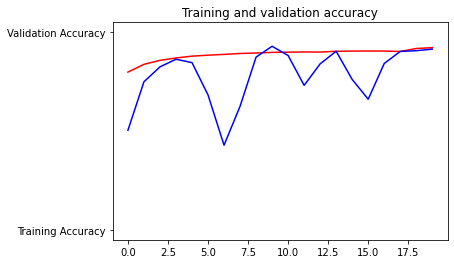

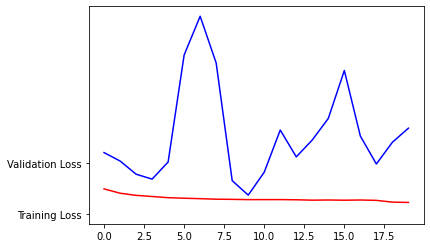

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline


#-----------------------------------------------------------
# Augmentation Data history 
#-----------------------------------------------------------
acc = hist_augmented.history['acc']
val_acc = hist_augmented.history['val_acc']
loss = hist_augmented.history['loss']
val_loss = hist_augmented.history['val_loss']
 
epochs = range(len(acc)) # epochs를 x축으로 둘 예정

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

<Figure size 432x288 with 0 Axes>

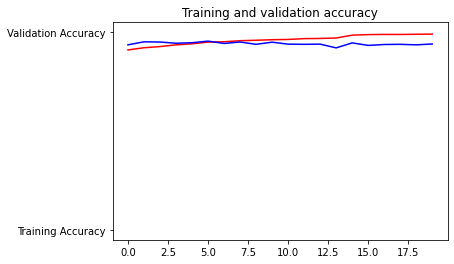

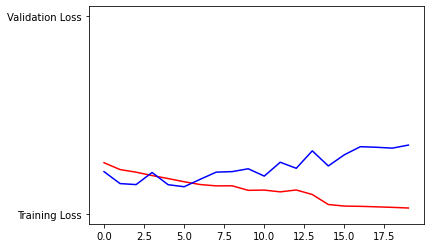

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline


#-----------------------------------------------------------
# 원본 데이터 history
#-----------------------------------------------------------
acc = hist_vertical.history['acc']
val_acc = hist_vertical.history['val_acc']
loss = hist_vertical.history['loss']
val_loss = hist_vertical.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [ ]:
model_final = keras.models.load_model(model_save_folder_path+"model_006-0.9551.hdf5")

### 2. 전이학습

In [ ]:
# 전이학습, RESNET 사용할꺼면 이 코드로 모델링

from tensorflow.keras.applications.resnet50 import ResNet50

Resnet50_base = ResNet50(weights='imagenet',
                     include_top=False,# 가장 상단(최신)의 fully connected layer (1x1)를 포함하느냐에 대한 물음. 
                                      # 최종적인 분류를 하는 층이기 때문에 False를 해줘야 이어서 학습시키는데 정확하다고 볼 수 있음
                     input_shape=(300, 300, 3))

Resnet50_base.trainable = False # RESNET을 통해 학습된 base 층은 학습시키지 않는다는 설정

Mobilnet_base = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(300, 300, 3),weights='imagenet',include_top=False )
Mobilnet_base.trainable = False
# conv_base.summary()

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
!nvidia-smi

Tue Aug 10 15:08:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |    476MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model_resnet = tf.keras.models.Sequential()
model_resnet.add(Resnet50_base)
model_resnet.add(keras.layers.Flatten())
model_resnet.add(keras.layers.Dense(128, activation=None))
model_resnet.add(keras.layers.BatchNormalization())
model_resnet.add(keras.layers.Activation('relu'))
model_resnet.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_resnet.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
reduce_lr = ReduceLROnPlateau(patience=8,verbose=1) # 8번의 epoch가 지났는데도 개선이 없으면, learning rate를 수정함
early_stop = EarlyStopping(patience=10,verbose=2,monitor='val_loss')

res_path= './drive/MyDrive/res_model/'
if not os.path.exists(res_path): #없으면 model 폴더 생성
  os.mkdir(res_path)

model_res_path = res_path + 'model_{epoch:03d}-{val_acc:.4f}.hdf5' 

res_ckpt = ModelCheckpoint(filepath=model_res_path,
                             monitor='val_loss',
                                verbose=1, 
                             save_best_only=True
                             )
res_ckpt_new = ModelCheckpoint(filepath=model_res_path,
                             monitor='val_loss',
                             verbose=1, 
                             )  

In [ ]:
hist_res_first = model_resnet.fit(
      train_generator_augmented,
      epochs=20,
      verbose=1,
      validation_data = test_generator, #, #validation data로 test data를 넣음. 1) 그래프그리려고, 2) test accuracy보려고
      callbacks=[res_ckpt,reduce_lr,early_stop]
      )

Epoch 1/20
303/303 [==============================] - 274s 794ms/step - loss: 0.4515 - acc: 0.8127 - val_loss: 25.7224 - val_acc: 0.1114

Epoch 00001: val_loss improved from inf to 25.72243, saving model to ./drive/MyDrive/res_model/model_001-0.1114.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
303/303 [==============================] - 240s 790ms/step - loss: 0.3886 - acc: 0.8431 - val_loss: 5.9188 - val_acc: 0.9128

Epoch 00002: val_loss improved from 25.72243 to 5.91879, saving model to ./drive/MyDrive/res_model/model_002-0.9128.hdf5
Epoch 3/20
303/303 [==============================] - 239s 788ms/step - loss: 0.3740 - acc: 0.8524 - val_loss: 63.3493 - val_acc: 0.0872

Epoch 00003: val_loss did not improve from 5.91879
Epoch 4/20
303/303 [==============================] - 237s 783ms/step - loss: 0.3690 - acc: 0.8557 - val_loss: 2.5567 - val_acc: 0.7385

Epoch 00004: val_loss improved from 5.91879 to 2.55666, saving model to ./drive/MyDrive/res_model/model_004-0.7385.hdf5
Epoch 5/20
303/303 [==============================] - 239s 787ms/step - loss: 0.3531 - acc: 0.8599 - val_loss: 1.2260 - val_acc: 0.8769

Epoch 00005: val_loss improved from 2.55666 to 1.22603, saving model to ./drive/MyDrive/res_model/model_005-0.8769.hdf5
Epoch 6/20
303/303 [===================

In [ ]:
# augmented data로 학습시킨 model중 loss, val_loss 및 accuracy를 기반으로 model choice
model_resnet_choiced = keras.models.load_model(res_path+"model_005-0.8769.hdf5")

In [ ]:
hist_res_second = model_resnet_choiced.fit(
      train_generator_vertical,
      epochs=20,
      verbose=1,
      validation_data = test_generator, #, #validation data로 test data를 넣음. 1) 그래프그리려고, 2) test accuracy보려고
      callbacks=[res_ckpt_new,reduce_lr]
      )

Epoch 1/20
303/303 [==============================] - 72s 231ms/step - loss: 0.3167 - acc: 0.8810 - val_loss: 0.2806 - val_acc: 0.9209

Epoch 00001: saving model to ./drive/MyDrive/res_model/model_001-0.9209.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
303/303 [==============================] - 69s 228ms/step - loss: 0.2649 - acc: 0.9003 - val_loss: 0.1735 - val_acc: 0.9353

Epoch 00002: saving model to ./drive/MyDrive/res_model/model_002-0.9353.hdf5
Epoch 3/20
303/303 [==============================] - 69s 228ms/step - loss: 0.2306 - acc: 0.9116 - val_loss: 1.1859 - val_acc: 0.4771

Epoch 00003: saving model to ./drive/MyDrive/res_model/model_003-0.4771.hdf5
Epoch 4/20
303/303 [==============================] - 69s 228ms/step - loss: 0.1993 - acc: 0.9282 - val_loss: 0.2931 - val_acc: 0.9191

Epoch 00004: saving model to ./drive/MyDrive/res_model/model_004-0.9191.hdf5
Epoch 5/20
303/303 [==============================] - 69s 228ms/step - loss: 0.1726 - acc: 0.9383 - val_loss: 0.5757 - val_acc: 0.9137

Epoch 00005: saving model to ./drive/MyDrive/res_model/model_005-0.9137.hdf5
Epoch 6/20
303/303 [==============================] - 69s 228ms/step - loss: 0.1449 - acc: 0.9482 - val_loss: 0.2410 - val_acc: 0.9272

Epoch 00006:

In [ ]:
model_resnet_final = keras.models.load_model(res_path+"model_009-0.9470")

### 최종 비교

In [ ]:
if not os.path.exists(os.path.join('input_images')):
  os.mkdir(os.path.join('input_images'))

In [ ]:
model_final = keras.models.load_model("./drive/MyDrive/final_model/model_006-0.9551.hdf5")
model_final.evaluate(test_generator)

35/35 [==============================] - 34s 113ms/step - loss: 0.1375 - acc: 0.9551


[0.13749301433563232, 0.9550763964653015]

In [ ]:
model_resnet_final = keras.models.load_model("./drive/MyDrive/res_model/model_009-0.9470.hdf5")
model_resnet_final.evaluate(test_generator)

35/35 [==============================] - 10s 221ms/step - loss: 0.1685 - acc: 0.9470


[0.1684785783290863, 0.9469901323318481]

In [ ]:
# model predict
def predict_fn(path,model):
  img = cv2.imread(path)
  img = img*(1./255)
  img = cv2.resize(img,(300,300))
  img = img.astype('float32')
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
  img = img.reshape(1,300,300,3)
  return round(model.predict(img)[0][0]*100,2)

In [ ]:
print(predict_fn('/content/images/point/point (1).jpg',model_final))

96.22

In [ ]:
if not os.path.exists(os.path.join('input_images')):
  os.mkdir(os.path.join('input_images'))
print(predict_fn('/content/input_images/test_cut.jpg',model_final))
print(predict_fn('/content/input_images/test_cut.jpg',model_resnet_final))

91.55
97.0


In [ ]:
# DJANGO 판정 (get_point.py)
# from django.conf import settings
# from tensorflow.keras import models
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import numpy as np
# import cv2


# def predict_fn(path):
#   base_dir = settings.MEDIA_ROOT_URL + settings.MEDIA_URL # == './media/'
#   model_dir = base_dir + 'model_final.hdf5'
#   model = models.load_model(model_dir, compile=False)

#   img = cv2.imread(path)
#   img = img*(1./255)
#   img = cv2.resize(img,(300,300))
#   img = img.astype('float32')
#   img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
#   img = img.reshape(1,300,300,3)
#   result = str(round(model.predict(img)[0][0]*100,2))+"% 확률로 적립금이 지급됩니다."

#   return result


## 🔟휴지통

In [ ]:
# # in colab, jupyter 
# # ImageDataGenerator를 통한 판정
# def predict_fn(path='input_images'):
#   input_dir = os.path.join('input_images/input_img')
#   to_dir = os.path.join('predicted_img')
#   model_dir = "model/model_final.hdf5"
#   if not os.path.exists(input_dir):
#     os.mkdir(input_dir)

#   if not os.path.exists(to_dir):
#     os.mkdir(to_dir)
#   try:


#     model_final = keras.models.load_model(model_dir)
#     input_datagen = ImageDataGenerator(rescale = 1./255,)
#     input_generator = input_datagen.flow_from_directory(
#         path,
#         target_size=(300, 300),
#         batch_size=128,
#         shuffle = False,
#         class_mode='binary',)
    
#     result = model_final.predict(input_generator)
#     max_result = max(result)[0]
     
#     for name in list(os.listdir(path+'/input_img')):
#       shutil.move(os.path.join(input_dir, name), 
#                 os.path.join(to_dir, name))
#     print('적립금 지급 확률 {:3.3f}%'.format(max_result*100))
#     return 
#   except:
#     return


#     # if max(result)>=0.8:
#     #   print('Point적립이 완료되었습니다.')
#     # elif max(result)>=0.2:
#     #   print('관리자 확인이 필요한 이미지입니다.')
#     # else :
#     #   print('이미지를 다시 올려주세요.(댓글이랑 연결 필요)')

#     # # 파일명을 구분할필요 없음?? 운영 : 회원id + 시간

#     predict_fn()

In [ ]:
# def cv_detect_fullbody(path): # path parameter를 통해 파일 경로를 받아들이게 됩니다.
#     img = cv2.imread(path,1)
# #     img = cv2.resize(img,(14,28))

#     if (type(img) is np.ndarray):
#         print(img.shape) # 세로, 가로, 채널

#         fullbody_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')

#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # detectMultiScale(Original img, ScaleFactor, minNeighbor) : further info. @ http://j.mp/2SxjtKR
#         fullbody = fullbody_cascade.detectMultiScale(gray, 1.05 , 3) 
#         for (x, y, w, h) in fullbody:
#             cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
#             roi_gray = gray[y:y+h, x:x+w]
#             roi_color = img[y:y+h, x:x+w]

#         cv2.imwrite(path, img)
#     else:
#         print('Error occurred within cv_detect_face!')
#         print(path)
        
        
#     return img

In [ ]:
# 전이학습, RESNET 사용할꺼면 이 코드로 모델링

# from tensorflow.keras.applications.resnet50 import ResNet50

# conv_base = ResNet50(weights='imagenet',
#                      include_top=False,
#                      input_shape=(300, 300, 3))
# conv_base.summary()



# model = tf.keras.models.Sequential()

# model.add(conv_base)
# model.add(layers.Flatten())

# # 우리가 직접 만드는 모델을 하단에
# model.add(layers.Dense(128, activation=None))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(64, activation=None))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# 필요없어진듯?
# # resize 함수

# def resize_imgs(path):
#     img = cv2.imread(path)
#     if max(img.shape)>256:
        
#         #세로가 256 px 이상이고 세로로 긴 경우
#         if img.shape[0] == max(img.shape):
#             new_w = img.shape[1] * (256.0/img.shape[1])
#             new_h = img.shape[0] * (256.0/img.shape[1])
#         #가로가 256 px 이상이고 세로로 긴 경우
#         elif img.shape[1] == max(img.shape):
#             new_w = img.shape[1] * (256.0/img.shape[0])
#             new_h = img.shape[0] * (256.0/img.shape[0])
#     else:
#             new_w=img.shape[1]
#             new_h=img.shape[0]
            
#     img = cv2.resize(img, (int(new_w), int(new_h)))
#     return img

### HPO (with. Kerastuner)

In [ ]:
# !pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 4.2 MB/s 


In [ ]:
# from keras import initializers
# import kerastuner as kt

# import IPython

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
# def build_hyper_model(hp):
    
#     model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3),padding='same'),
#     tf.keras.layers.MaxPooling2D(2, 2)])

#     for i in range(hp.Int('num_layers', min_value=3, max_value=5)):

#         hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32) # 퍼셉트론수를 32~512개로 정하고, 32를 단위로 조정함
#         hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu']) #activation function은 relu, elu중에 하나
#         model.add(tf.keras.layers.Conv2D(hp_units,(3,3), activation = hp_activations, padding='same'))
#         model.add(tf.keras.layers.MaxPooling2D(2,2))
    
#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(512, activation='relu'))
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#     # learning rate choice
#     hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
#     model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
#                 loss = keras.losses.MeanSquaredError(),
#                 metrics = keras.metrics.Accuracy)
    
#     return model

In [ ]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("\nAll devices: ", tf.config.list_logical_devices('TPU'))

# strategy = tf.distribute.TPUStrategy(resolver) # Obsolete : tf.distribute.experimental.TPUStrategy()


# project_name ='Musinsa'

# with strategy.scope(): 

#     # model = create_model(max_length=128) # TPU Cluster 상에서 모델 생성 & Compile 진행
#     tuner = kt.BayesianOptimization(build_hyper_model,
#                                 objective =  'acc',#'loss', # val_loss, val_acc, acc 가능.
#                                 max_trials = 10,
#                                 directory = 'content',
#                                 project_name = 'Musinsa'
#                                 )
    

#     tuner.search(train_generator, epochs=20, validation_data = test_generator)

In [ ]:
# tuner = kt.BayesianOptimization(build_hyper_model,
#                                 objective = 'loss', # val_loss, val_acc, acc 가능.
#                                 max_trials = 10,
#                                 directory = 'content',
#                                 project_name = 'Musinsa',
#                                 )
#  tuner.search(train_generator, epochs=20, validation_data = test_generator)                       

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-10-cc1b49689b60>", line 23, in build_hyper_model
    metrics = keras.metrics.Accuracy)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 570, in compile
    self._validate_compile(optimizer, metrics, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 2642, in _validate_compile
    for v in getattr(metric, 'variables', []):
TypeError: 'property' object is not iterable
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-10-cc1b49689b60>", line 23, in build_hyper_model
    metrics = keras.metrics.Accuracy)
  File "/usr/local/lib/python3.7/dist-packages

Invalid model 0/5
Invalid model 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-10-cc1b49689b60>", line 23, in build_hyper_model
    metrics = keras.metrics.Accuracy)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 570, in compile
    self._validate_compile(optimizer, metrics, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 2642, in _validate_compile
    for v in getattr(metric, 'variables', []):
TypeError: 'property' object is not iterable
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-10-cc1b49689b60>", line 23, in build_hyper_model
    metrics = keras.metrics.Accuracy)
  File "/usr/local/lib/python3.7/dist-packages

Invalid model 2/5
Invalid model 3/5
Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-10-cc1b49689b60>", line 23, in build_hyper_model
    metrics = keras.metrics.Accuracy)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 570, in compile
    self._validate_compile(optimizer, metrics, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 2642, in _validate_compile
    for v in getattr(metric, 'variables', []):
TypeError: 'property' object is not iterable
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-10-cc1b49689b60>", line 23, in build_hyper_model
    metrics = keras.metrics.Accuracy)
  File "/usr/local/lib/python3.7/dist-packages

RuntimeError: ignored

In [ ]:
# # best 3 model
# tuner.search(train_generator, epochs=20, validation_data = test_generator)
# tuner.results_summary(num_trials=3)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
num_layers        |5                 |?                 
units_0           |448               |?                 
activation_0      |elu               |?                 
units_1           |480               |?                 
activation_1      |relu              |?                 
units_2           |384               |?                 
activation_2      |relu              |?                 
learning_rate     |0.0001            |?                 

Epoch 1/20


ResourceExhaustedError: ignored

In [ ]:
# top3_models = tuner.get_best_hyperparameters(num_trials=3)

In [ ]:
# best_hps = top3_models[0]

In [ ]:
# print("""
# The hyperparameter search is complete. 
# * Optimal # of layers : {}
# * Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

# for layer_num in range(best_hps.get('num_layers')):
#     print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
#     print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))

In [ ]:
# models = tuner.get_best_models(num_models=3)
# top_model = models[0]
# top_model.summary()
# print()

# results = top_model.evaluate(test_generator)
# print('Cross-entropy :', results[0])
# print('Accuracy :', results[1])

In [ ]:
# for trial in tuner.oracle.get_best_trials(num_trials=3):
#     print('Trial-score is :', trial.score)
#     print('Trial-directory(trial_id) is :', trial.trial_id)
#     print()

In [ ]:
# # model saving
# models[0].save("model/top_model.h5")

In [ ]:
# # 재검증
# keras.models.load_model("model/top_model.h5").evaluate(test_generator)